In [1]:
bucket = "mufg-data-sandbox-us-east-1-sagemaker"
prefix = "sagemaker/recommendation"

#Define IAM role
import boto3
import re
from sagemaker import get_execution_role
#role = get_execution_role()
role = "arn:aws:iam::476054568469:role/SageMakerExecutionRole-us-east-1"
kms_key="arn:aws:kms:us-east-1:476054568469:key/44d350fa-2751-42ce-8389-b9e98130da58"
extra_args={
    "ServerSideEncryption": "aws:kms",
    "SSEKMSKeyId": kms_key
}
subnets=['subnet-0be1d0f0d5b54e56d', 'subnet-052c7e710f9c47efb']
security_group_ids=['sg-0197fc87ee3393d12', 'sg-0a589e5446f15ae9f']

In [5]:
pip install https://github.com/aws-samples/sagemaker-run-notebook/releases/download/v0.18.0/sagemaker_run_notebook-0.18.0.tar.gz

ERROR: Could not install packages due to an EnvironmentError: HTTPSConnectionPool(host='github.com', port=443): Max retries exceeded with url: /aws-samples/sagemaker-run-notebook/releases/download/v0.18.0/sagemaker_run_notebook-0.18.0.tar.gz (Caused by ConnectTimeoutError(<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f88297c3780>, 'Connection to github.com timed out. (connect timeout=15)'))

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
import sys
import math
import json
import os
import sagemaker
from sagemaker.predictor import csv_serializer

In [3]:
from datetime import date
import random
data1 = pd.read_csv("s3://mufg-data-sandbox-us-east-1-sagemaker/input/UCM_SANITIZED_EXAMPLE.csv", sep="|")
data1.head()

,Cycle Time(Business days),SANITIZEDCUSTOMERID,CaseTypeName,Market Segment,Products,CaseID,HED_CIFNumber,Work Completed,HED_OnboardingMilestone,HED_ServiceTag
0,67,20093,Onboarding,CBTS - North,ACH on the Web,10610981,119551396,In Progress,Account Onboarded,Platinum
1,147,61231,Maintenance,CBTS - South,Integrated Payables,11927403,161676909,In Progress,Legal Agreements and Document Execution,Platinum
2,146,60628,Existing Account/New Product,RetailWealth - Business Banking,Stop Payment,11908102,161059268,In Progress,Product Setup,Silver
3,74,23904,Existing Account/New Product,RetailWealth - Business Banking,Remote Deposit,13991793,203452851,In Progress,Product Setup,Silver
4,130,93473,Existing Account/New Product,RetailWealth - Business Banking,Remote Deposit,13232901,123454212,In Progress,Product Setup,Silver


In [4]:
from datetime import date
import random
data = pd.read_csv("s3://mufg-data-sandbox-us-east-1-sagemaker/input/UCM_SANITIZED_EXAMPLE.csv", sep="|")
data.head()

,Cycle Time(Business days),SANITIZEDCUSTOMERID,CaseTypeName,Market Segment,Products,CaseID,HED_CIFNumber,Work Completed,HED_OnboardingMilestone,HED_ServiceTag
0,67,20093,Onboarding,CBTS - North,ACH on the Web,10610981,119551396,In Progress,Account Onboarded,Platinum
1,147,61231,Maintenance,CBTS - South,Integrated Payables,11927403,161676909,In Progress,Legal Agreements and Document Execution,Platinum
2,146,60628,Existing Account/New Product,RetailWealth - Business Banking,Stop Payment,11908102,161059268,In Progress,Product Setup,Silver
3,74,23904,Existing Account/New Product,RetailWealth - Business Banking,Remote Deposit,13991793,203452851,In Progress,Product Setup,Silver
4,130,93473,Existing Account/New Product,RetailWealth - Business Banking,Remote Deposit,13232901,123454212,In Progress,Product Setup,Silver


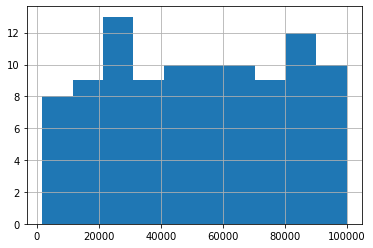

In [5]:
data['SANITIZEDCUSTOMERID'].hist()

In [6]:
import random
from scipy.sparse import lil_matrix

# get products
products = []
for idx, row in data.iterrows():
    product = row["Products"]
    if product not in products:
        products.append(product)
products.sort()
print(products)

nbCustomers = 100
nbProducts = len(products)
nbFeatures = nbCustomers + nbProducts
nbDataPoints = 5000
nbDataPointsTest=1000

#create synthetic customer data
def create_dataset(count):
    global nbCustomers, nbProducts, products
    headers = []
    for c in range(0, nbCustomers):
        headers.append("customer_"+str(c+1))
    for y in products:
        headers.append(y)
    headers.append("onboarded")
    data = []
    X = lil_matrix((count, nbCustomers+nbProducts)).astype("float32")
    Y= []
    for l in range(0,count):
        c=random.randrange(nbCustomers)
        X[l,c] = 1
        row=[]
        for a in range(0, nbCustomers):
            if a==c:
                row.append(1)
            else:
                row.append(0)
        p=random.randrange(len(products))
        X[l,nbCustomers+p] = 1
        for a in range(0,len(products)):
            if a==p:
                row.append(1)
            else:
                row.append(0)
        if random.random()>=0.70:
            Y.append(1)
            row.append(1)
        else:
            Y.append(0)
            row.append(0)
        data.append(row)
    Y=np.array(Y).astype("float32")
    d=pd.DataFrame(data,columns=headers)
    return X,Y,d

X_train, Y_train, df_train = create_dataset(nbDataPoints)
X_test, Y_test, df_test = create_dataset(nbDataPointsTest)

print(df_train)            

['ACH Direct Send/Vendor Send', 'ACH Exchange', 'ACH Prefund Direct Send/Vendor Send', 'ACH on the Web', 'Account Reconciliation/Deposit Reconciliation', 'Account Transfers', 'Alerts and Notifications', 'Electronic Data Exchange(EDI)/Receipt Services', 'Financial Center', 'IBB-Internet Business Banking', 'Image Cash Letter', 'Image On Demand', 'Information Reporting', 'Integrated Payables', 'Lockbox - Wholesale CA', 'Lockbox online', 'Misc', 'Online Statement', 'Positive Pay -  Standard', 'Positive Pay - Basic', 'Positive Pay - Payee', 'Remote Deposit', 'Returned Items on the web', 'Stop Payment', 'Sweep', 'Token Requested', 'Total Biller Solution', 'Web Commercial Loans', 'Wire Services(Direct Access)', 'Wire on the Web/Wire File Import']
      customer_1  customer_2  customer_3  customer_4  customer_5  customer_6  \
0              0           0           0           0           0           0   
1              0           0           0           0           0           0   
2         

In [7]:
print(X_train.shape, "X_train.shape!")
print(Y_train.shape, "Y_train.shape!")
assert X_train.shape == (nbDataPoints, nbFeatures)
assert Y_train.shape == (nbDataPoints,)
zero_labels = np.count_nonzero(Y_train)
print("Training labels:{0} zeroes, {1} ones".format(zero_labels, nbDataPoints-zero_labels))

print(X_test.shape, "X_test.shape!")
print(Y_test.shape, "Y_test.shape!")
assert X_test.shape == (nbDataPointsTest, nbFeatures)
assert Y_test.shape == (nbDataPointsTest,)
zero_labels = np.count_nonzero(Y_test)
print("Test labels:{0} zeroes, {1} ones".format(zero_labels, nbDataPointsTest-zero_labels))


(5000, 130) X_train.shape!
(5000,) Y_train.shape!
Training labels:1513 zeroes, 3487 ones
(1000, 130) X_test.shape!
(1000,) Y_test.shape!
Test labels:326 zeroes, 674 ones


In [8]:
train_key = "train.protobuf"
train_prefix = "{0}/{1}".format(prefix, "train")

test_key = "test.protobuf"
test_prefix = "{0}/{1}".format(prefix, "test")

output_location = "s3://{0}/{1}/output".format(bucket, prefix)

In [9]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon import common as smac
from sagemaker.predictor import json_deserializer
import io

def write_dataset_to_protobuf(X,Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{0}/{1}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return "s3://{0}/{1}".format(bucket, obj)

train_data = write_dataset_to_protobuf(X_train, Y_train, bucket, train_prefix, train_key)
test_data = write_dataset_to_protobuf(X_test, Y_test, bucket, test_prefix, test_key)


In [10]:
from sagemaker.amazon.amazon_estimator import get_image_uri
#boto3.setup_default_session(region_name='us-west-2')
container = get_image_uri(boto3.Session().region_name, "factorization-machines")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [11]:
#role = get_execution_role()
role = "arn:aws:iam::476054568469:role/SMTRN-us-east-1-SC-476054568469-pp-5kg5wagv7mzae"

In [14]:
sess = sagemaker.Session()

fm = sagemaker.estimator.Estimator(container,
                                   role,
                                   train_instance_count=1,
                                   train_instance_type="ml.c5.xlarge",
                                   output_path=output_location,
                                   sagemaker_session=sess,
                                   enable_network_isolation=True,
                                   encrypt_inter_container_traffic=True,
                                   output_kms_key=kms_key,
                                   train_volume_kms_key=kms_key,
                                   subnets=subnets,
                                   security_group_ids=security_group_ids
                                  )

fm.set_hyperparameters(feature_dim=nbFeatures,
                       predictor_type="binary_classifier",
                       mini_batch_size=1000,
                       num_factors=64,
                       epochs=100
                      )
fm.fit({'train': train_data, "test": test_data})

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-06 16:23:31 Starting - Starting the training job...
2020-10-06 16:23:33 Starting - Launching requested ML instances......
2020-10-06 16:24:36 Starting - Preparing the instances for training...
2020-10-06 16:25:29 Downloading - Downloading input data...
2020-10-06 16:26:00 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[10/06/2020 16:26:02 INFO 140239361763136] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_lo

In [17]:
vpc_config=dict(
    Subnets=subnets,
    SecurityGroupIds=security_group_ids
)
fm_predictor = fm.deploy(initial_instance_count=1,
                         instance_type="ml.c4.xlarge",
                         enable_network_isolation=True,
                         kms_key=kms_key,
                         vpc_config_override = vpc_config
                        )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [ ]:
!hostname

In [18]:
from datetime import datetime
endpoint_name = "factorization-machines-2020-07-28-21-37-20-287"
sess = sagemaker.Session()
fm_predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name, sagemaker_session=sess)

def fm_serializer(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    return json.dumps(js)
fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

In [19]:
# do recommendations for all customers
h=['customer', 'sales rep', 'product', 'recommendation_score']
d=[]
for custId in range(0, nbCustomers):
    customerProducts=[]
    salesId=random.randrange(10)+1
    
    for idx, row in df_train.iterrows():
        if row['customer_'+str(custId+1)]==1 and row['onboarded']==1:
            for y in products:
                if row[y]==1 and y not in customerProducts:
                    customerProducts.append(y)
    customerProducts.sort()
    
    newProducts=[]
    for y in products:
        if y not in customerProducts:
            newProducts.append(y)
    
    for z in newProducts:
        testRow=[]
        for x in range(0, nbCustomers):
            if x+1==custId:
                testRow.append(1)
            else:
                testRow.append(0)
        productIdx=products.index(z)
        
        for a in range(0, len(products)):
            if a==productIdx:
                testRow.append(1)
            else:
                testRow.append(0)
        testRow=np.array(testRow)
        res=fm_predictor.predict([testRow])
        score=res['predictions'][0]['score']
        r=[]
        r.append('Customer_'+str(custId+1))
        r.append("Sales Rep_"+str(salesId))
        r.append(z)
        r.append(score)
        print(r)
        d.append(r)
dfReport=pd.DataFrame(d, columns=h)
print(dfReport)

['Customer_1', 'Sales Rep_2', 'ACH Direct Send/Vendor Send', 0.3543422520160675]
['Customer_1', 'Sales Rep_2', 'ACH Prefund Direct Send/Vendor Send', 0.3329625427722931]
['Customer_1', 'Sales Rep_2', 'ACH on the Web', 0.3121902048587799]
['Customer_1', 'Sales Rep_2', 'Alerts and Notifications', 0.31290432810783386]
['Customer_1', 'Sales Rep_2', 'Image Cash Letter', 0.2666513919830322]
['Customer_1', 'Sales Rep_2', 'Image On Demand', 0.38043704628944397]
['Customer_1', 'Sales Rep_2', 'Integrated Payables', 0.34045618772506714]
['Customer_1', 'Sales Rep_2', 'Lockbox - Wholesale CA', 0.292153000831604]
['Customer_1', 'Sales Rep_2', 'Online Statement', 0.313125342130661]
['Customer_1', 'Sales Rep_2', 'Positive Pay -  Standard', 0.28867101669311523]
['Customer_1', 'Sales Rep_2', 'Positive Pay - Basic', 0.32587966322898865]
['Customer_1', 'Sales Rep_2', 'Stop Payment', 0.33758050203323364]
['Customer_1', 'Sales Rep_2', 'Sweep', 0.32025346159935]
['Customer_1', 'Sales Rep_2', 'Web Commercial 

In [ ]:
from s3fs.core import S3FileSystem
s3 = S3FileSystem(anon=False)
with s3.open("s3://mufg-data-sandbox-us-east-1-sagemaker/output/recommendation.csv",'w') as f:
    dfReport.to_csv(f, index=False, header=True)

In [ ]:
!pip list

In [20]:
!git add *
!git commit -m "recommendation poc notebook"
!git config --global user.name "Maheshbabu Thummati"
!git config --global user.email maheshbabu.thummati@gmail.com

[master dabbc3b] recommendation poc notebook
 1 file changed, 4461 insertions(+), 4805 deletions(-)


In [ ]:
!git push origin